<a href="https://colab.research.google.com/github/Gogalino/Transcriptomics/blob/main/HW2_Linovskiy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop #4. Statistical analysis of bulk RNA-seq

### Daniil Bobrovskiy, tg @daniilbobrovskiy

## Introduction

In [ ]:
# download data
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz

# unzip count matrices
!gunzip GSE110021_counts.Aug2015.txt.gz

--2024-07-14 01:31:44--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067815 (1.0M) [application/x-gzip]
Saving to: ‘GSE110021_counts.Aug2015.txt.gz’

GSE110021_counts.Au 100%[===================>]   1.02M   844KB/s    in 1.2s    

2024-07-14 01:31:46 (844 KB/s) - ‘GSE110021_counts.Aug2015.txt.gz’ saved [1067815/1067815]



Now, we will install and load the required packages. One of them is Rpy2, which allows us to work in R from GoogleColab. Actually, it even allows to pass the objects between Python and R, but we won't use this feature in this tutorial.

In [ ]:
!echo "deb http://security.ubuntu.com/ubuntu focal-security main" | sudo tee /etc/apt/sources.list.d/focal-security.list
!apt-get update
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libssl1.1

!pip install --upgrade gdown
!gdown 1XAbJa_suP-WFTKK628oM9EWsV7k-6fI9
!gdown 1Bt4HDrZqFId_7Ph99pSvhfFHxyrV-kaL
!tar xf library.tar.gz

deb http://security.ubuntu.com/ubuntu focal-security main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubu

In [ ]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("VennDiagram")'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/statmod_1.5.0.tar.gz'
Content type 'application/x-gzip' length 92486 bytes (90 KB)
downloaded 90 KB

* installing *source* package ‘statmod’ ...
** package ‘statmod’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using Fortran compiler: ‘GNU Fortran (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-avGvPq/r-base-4.4.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c expectedDeviance.c -o expectedDeviance.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-avGvPq/r-base-4.4.1=. -fstack-protector-strong  -c gaussq2.f -o gaussq2.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-avGvPq/r-base-4.4.

In [ ]:
%%R
suppressPackageStartupMessages({
  library(ggplot2)
  library(ggrepel)
  library(stringr)
  library(dplyr)
  library(edgeR)
})

## Exercise

At home, perform the same analysis with the standard DESeq2 pipeline. DESeq2 documentation is very detailed: https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html. For each step, comment, how it relates to what we did in edgeR.

You can then compare lists of differentially expressed genes between edgeR and DESeq2 using Venn diagrams or plot the p-values of different genes in edgeR and DESeq2 against each other.

And feel free to ask questions! @daniilbobrovskiy

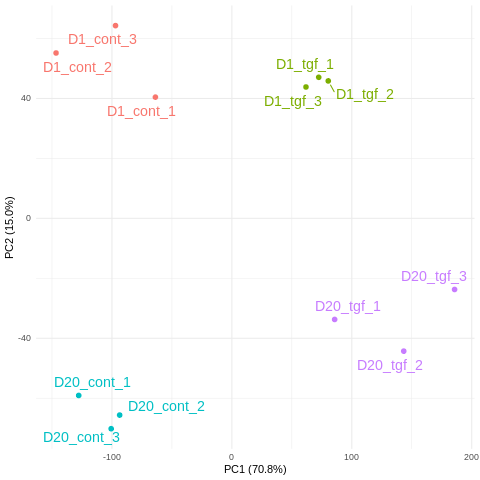

In [78]:
%%R

#Подготовка данных аналогично edgeR
# load data; since the authors didn't merge the lanes, we'll have to do it ourselves
counts <- read.table("GSE110021_counts.Aug2015.txt")
#print(head(counts))
counts <- data.frame(D1_cont_1=rowSums(select(counts, starts_with("D1.noTGFb.1"))),
                     D1_cont_2=rowSums(select(counts, starts_with("D1.noTGFb.2"))),
                     D1_cont_3=rowSums(select(counts, starts_with("D1.noTGFb.3"))),
                     D1_tgf_1=rowSums(select(counts, starts_with("D1.TGFb.1"))),
                     D1_tgf_2=rowSums(select(counts, starts_with("D1.TGFb.2"))),
                     D1_tgf_3=rowSums(select(counts, starts_with("D1.TGFb.3"))),
                     D20_cont_1=rowSums(select(counts, starts_with("D20.noTGFb.1"))),
                     D20_cont_2=rowSums(select(counts, starts_with("D20.noTGFb.2"))),
                     D20_cont_3=rowSums(select(counts, starts_with("D20.noTGFb.3"))),
                     D20_tgf_1=rowSums(select(counts, starts_with("D20.TGFb.1"))),
                     D20_tgf_2=rowSums(select(counts, starts_with("D20.TGFb.2"))),
                     D20_tgf_3=rowSums(select(counts, starts_with("D20.TGFb.3"))))

biomart <- read.table("biomart_hg19_ensembl75.tsv", sep="\t", header=TRUE)

protein_coding <- biomart$Gene.type[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)] == "protein_coding"
protein_coding[is.na(protein_coding)] <- FALSE
counts <- counts[protein_coding,]
ensembl <- biomart$Gene.stable.ID[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]
symbol <- biomart$Gene.name[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]

# scale the data
counts_scaled <- t(scale(counts))
#counts_scaled <- t(counts)
# run PCA
pca_result <- prcomp(counts_scaled, center = TRUE, scale. = TRUE)
variance_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

# extract first two PCs
scores_df <- data.frame(PC1 = pca_result$x[,1], PC2 = pca_result$x[,2])
scores_df$Sample = row.names(scores_df)
groups <- str_remove(scores_df$Sample, "_[0-9]+$")
scores_df$group = groups

# plot first two PCs
ggplot(scores_df, aes(x = PC1, y = PC2, label = Sample, color = group)) +
  geom_point(size=2) +
  geom_text_repel(size=5,
                  box.padding = 0.5,
                  point.padding = 0.5,
                  max.overlaps = Inf)+
  theme_minimal()+
  theme(legend.position = "none")+
  labs(x=paste("PC1 (", sprintf("%.1f", variance_explained[1]), "%)", sep=""),,
       y=paste("PC2 (", sprintf("%.1f", variance_explained[2]), "%)", sep=""),)

In [79]:
%%R
suppressPackageStartupMessages(library(DESeq2))

In [80]:
%%R
colData <- data.frame(group = groups)
rownames(colData) <- colnames(counts)


In [81]:
%%R
# Создание DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = colData,
                              design = ~ group)


#Добавление информации о кодах генов

gene_annotations <- data.frame(
  ensembl = ensembl,
  symbol = symbol
)

rownames(gene_annotations) <- rownames(counts)
rownames(dds) <- gene_annotations$symbol



In [82]:
%%R
dds

class: DESeqDataSet 
dim: 19016 12 
metadata(1): version
assays(1): counts
rownames(19016): OR4F5 OR4F29 ... BPY2B CDY1B
rowData names(0):
colnames(12): D1_cont_1 D1_cont_2 ... D20_tgf_2 D20_tgf_3
colData names(1): group


In [ ]:
%%R
smallestGroupSize <- 3
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
y = dds[keep,]

In [ ]:
%%R
y

class: DESeqDataSet 
dim: 12606 12 
metadata(1): version
assays(1): counts
rownames(12606): SAMD11 NOC2L ... TMLHE VAMP7
rowData names(0):
colnames(12): D1_cont_1 D1_cont_2 ... D20_tgf_2 D20_tgf_3
colData names(2): colnames.count_matrix. groups


In [84]:
%%R
#Обработка данных, оценка дисперсии, построение модели
dds_processed <- DESeq(y)


In [85]:
%%R
#Вычисление результатов с нужными контрастами
results_cont_20vs1 <- results(dds_processed, contrast = c('groups', 'D1_cont', 'D20_cont'))
results_tgf_20vs1 <- results(dds_processed, contrast = c('groups', 'D1_tgf', 'D20_tgf'))
results_d1_tgf <- results(dds_processed, contrast = c('groups', 'D1_cont', 'D1_tgf'))
results_d20_tgf <- results(dds_processed, contrast = c('groups', 'D20_cont', 'D20_tgf'))


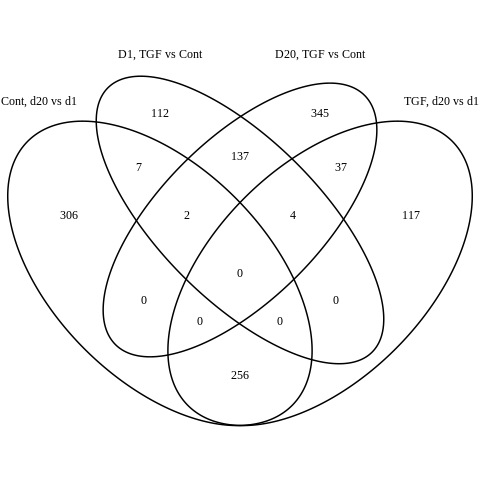

In [86]:
%%R
#Построение диаграммы Венна
de_genes_cont_20vs1 <- row.names(subset(results_cont_20vs1, padj < 0.05 & log2FoldChange > 1))
de_genes_tgf_20vs1 <- row.names(subset(results_tgf_20vs1, padj < 0.05 & log2FoldChange > 1))
de_genes_d1_tgf <- row.names(subset(results_d1_tgf, padj < 0.05 & log2FoldChange > 1))
de_genes_d20_tgf <- row.names(subset(results_d20_tgf, padj < 0.05 & log2FoldChange > 1))


# Use VennDiagram package to plot the Venn diagram
library(VennDiagram)
venn.plot <- venn.diagram(
  x = list(
    Cont_20vs1 = de_genes_cont_20vs1,
    TGF_20vs1 = de_genes_tgf_20vs1,
    D1_TGF = de_genes_d1_tgf,
    D20_TGF = de_genes_d20_tgf
  ),
  category.names = c("Cont, d20 vs d1", "TGF, d20 vs d1", "D1, TGF vs Cont", "D20, TGF vs Cont"),
  filename = NULL
)
grid.draw(venn.plot)